In [1]:
import pandas as pd
import math
import statsmodels.api as sm
import numpy as np
import scipy
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.model_selection import train_test_split

#### Note that the first 1460 samples in cleaned_data.csv are training and cleaned_data.csv does not have sale price in it. 

In [2]:
cleaned_data = pd.read_csv('E:/projects/housing_price/data/cleaned_data.csv',index_col=0)

#### Isolate the response vector 'SalePrice'

In [3]:
house_price = pd.read_csv('E:/projects/housing_price/data/train.csv',index_col=0)['SalePrice']

#### Examine correlations among variables

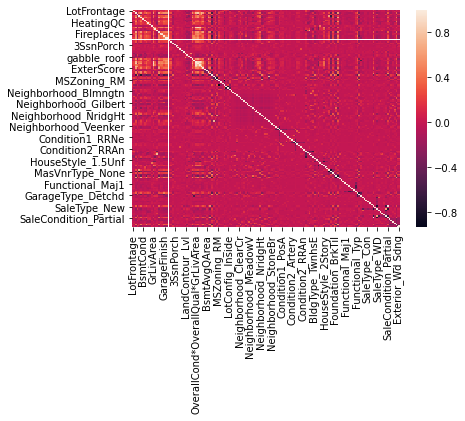

In [4]:
sns.heatmap(cleaned_data.corr())
plt.show()

#### It can be seen that there are highly correlated variables

In [5]:
correlation = cleaned_data.corr()

In [6]:
significantly_correlated = set()
for var1 in set(correlation):
    for var2 in set(correlation):
        if correlation.loc[var1][var2]>0.8 and var1!=var2:
            significantly_correlated.add(tuple(sorted([var1,var2])))

In [7]:
print("The highly correlated couples are: {}".format(significantly_correlated))

The highly correlated couples are: {('OverallCond*OverallQual*GrLivArea', 'OverallQual*GrLivArea'), ('GrLivArea', 'OverallCond*GrLivArea'), ('GrLivArea', 'OverallQual*GrLivArea'), ('OverallQual', 'OverallQual*GrLivArea'), ('OverallCond*GrLivArea', 'OverallCond*OverallQual*GrLivArea'), ('FireplaceQu', 'Fireplaces'), ('SaleCondition_Partial', 'SaleType_New'), ('GrLivArea', 'OverallCond*OverallQual*GrLivArea')}


#### As is said in readme.txt file, SaleCondition_Partial means when the house is sold, the house is only partially completed which also means that the house is a new house! So we can safely delete one of these categorical variables. 

In [8]:
cleaned_data = cleaned_data.drop(columns=['SaleCondition_Partial'])

#### Take a look at the other pair of high correlation

In [9]:
correlation.loc['FireplaceQu']['Fireplaces']

0.8617353520998596

#### We should remove one of the two, lets remove 'Fireplaces'

In [10]:
cleaned_data = cleaned_data.drop(columns=['Fireplaces'])

#### Check again for highly correlated pairs

In [11]:
significantly_correlated = set()
for var1 in set(cleaned_data.corr()):
    for var2 in set(cleaned_data.corr()):
        if correlation.loc[var1][var2]>0.8 and var1!=var2:
            significantly_correlated.add(tuple(sorted([var1,var2])))
if len(significantly_correlated)==0:
    print("There is no more highly correlated variables")
else:
    print("The highly correlated couples are: {}".format(significantly_correlated))

The highly correlated couples are: {('OverallCond*OverallQual*GrLivArea', 'OverallQual*GrLivArea'), ('GrLivArea', 'OverallCond*GrLivArea'), ('GrLivArea', 'OverallQual*GrLivArea'), ('OverallQual', 'OverallQual*GrLivArea'), ('OverallCond*GrLivArea', 'OverallCond*OverallQual*GrLivArea'), ('GrLivArea', 'OverallCond*OverallQual*GrLivArea')}


#### Now there is no more highly correlated pairs (other than interaction terms).

# Splitting Train and Test Data

In [12]:
train_data = cleaned_data.head(1460)
test_data = cleaned_data.tail(1459)

# Outliers

#### It is a common sense that the lot area and the living area of the house are usually the most important factors for housing price, so we can plot the area against sale price to see if there is anything unusual.

## Lot Area vs Sale Price

Text(0, 0.5, 'house price')

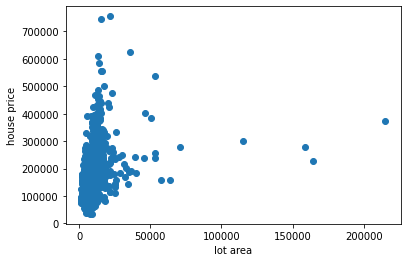

In [13]:
lot_area = train_data['LotArea']

plt.scatter(lot_area,house_price)
plt.xlabel('lot area')
plt.ylabel('house price')

#### There are four outliers with high leverage. We need to remove them. 

In [14]:
# First, to identify the ID's of the houses with the 4 largest lot area, we sort the data frame by lot area.
print(train_data.sort_values('LotArea',ascending=False)['LotArea'][:6])

Id
314     215245
336     164660
250     159000
707     115149
452      70761
1299     63887
Name: LotArea, dtype: int64


In [15]:
# Now, drop them
train_data = train_data.drop(index=[314,336,250,707,452,1299])

In [16]:
house_price = house_price.drop(index=[314,336,250,707,452,1299])

#### Look at the lot again

Text(0, 0.5, 'house price')

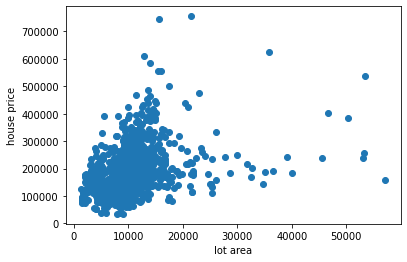

In [17]:
lot_area = train_data['LotArea']

plt.scatter(lot_area,house_price)
plt.xlabel('lot area')
plt.ylabel('house price')

## Living Area vs Sale Price

Text(0, 0.5, 'house price')

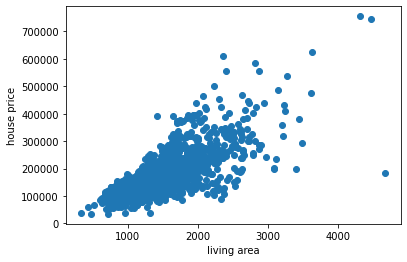

In [18]:
living_area = train_data['GrLivArea']

plt.scatter(living_area,house_price)
plt.xlabel('living area')
plt.ylabel('house price')

#### It is very clear that there are three outliers. Identify and remove them.

In [19]:
# the one with large area but low sale price
print(living_area.sort_values(ascending=False)[:1])

Id
524    4676
Name: GrLivArea, dtype: int64


In [20]:
# the two with very high sale price
print(house_price.sort_values(ascending=False)[:2])

Id
692     755000
1183    745000
Name: SalePrice, dtype: int64


In [21]:
train_data = train_data.drop(index=[524,692,1183])
house_price = house_price.drop(index=[524,692,1183])

#### Plot again

Text(0, 0.5, 'house price')

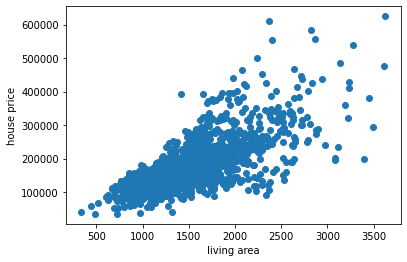

In [22]:
living_area = train_data['GrLivArea']

plt.scatter(living_area,house_price)
plt.xlabel('living area')
plt.ylabel('house price')

#### Due to the main effect of living_area on SalePrice, this plot here shows heterscedesticity. We should be using weighted least square instead of ordinary least square as the data encodes homoscedestic. But anyhow, lets still get the baseline model out as a basic benchmark. The basic residuals of ordinary least square will also help us determine the weights of weighted least square.

# Distribution of Y

#### In linear regression, we assumed normality of Y, we need to verify this. 

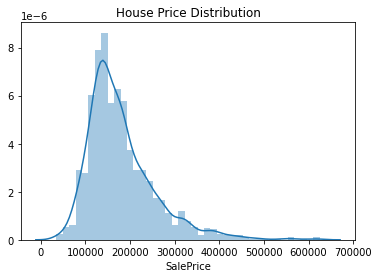

In [23]:
sns.distplot(house_price)
plt.title('House Price Distribution')
plt.show()

#### The distribution looks skewed, we consider either take log or take square-root.

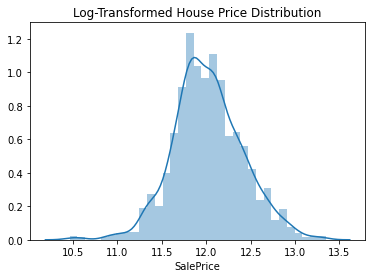

In [24]:
# Taking log
log_house_price = np.log(house_price)
sns.distplot(log_house_price)
plt.title('Log-Transformed House Price Distribution')
plt.show()

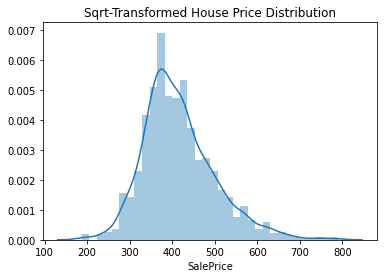

In [25]:
sqrt_house_price = np.sqrt(house_price)
sns.distplot(sqrt_house_price)
plt.title('Sqrt-Transformed House Price Distribution')
plt.show()

#### Based on what we see, the log-transformed house price is closer to normal distribution. So we will use log-transformed data, however it seems like there are three exceptionally low sale prices which introduced a little bit of skewness into the distribution. We need to remove them before use.

In [26]:
print(log_house_price.sort_values()[:3])

Id
496    10.460242
917    10.471950
969    10.542706
Name: SalePrice, dtype: float64


In [27]:
house_price = house_price.drop(index=[496,917,969])
log_house_price = log_house_price.drop(index=[496,917,969])
train_data = train_data.drop(index=[496,917,969])

Text(0.5, 1.0, 'log-transformed house price after removing outliers')

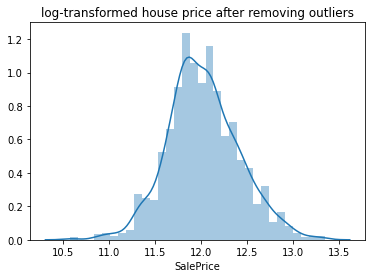

In [28]:
sns.distplot(log_house_price)
plt.title('log-transformed house price after removing outliers')

# Linear Regression Fit

In [29]:
data = sm.add_constant(train_data)
OLS = sm.OLS(log_house_price,train_data)
lin_regression = OLS.fit()
print(lin_regression.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     143.2
Date:                Thu, 16 Jul 2020   Prob (F-statistic):               0.00
Time:                        11:44:27   Log-Likelihood:                 1300.6
No. Observations:                1448   AIC:                            -2331.
Df Residuals:                    1313   BIC:                            -1619.
Df Model:                         134                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
LotFro

D:\anaconda\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


#### If we were doing a train-validation split on the training data, we can use the second half of the code below to compare the results. But since we have known that the regression model (with our carefully chose features) is very robust, we go ahead without validating.

In [40]:
train_fitted_log_price = lin_regression.predict(train_data)
train_fitted_price = np.exp(train_fitted_log_price)
train_percentage_error = np.abs(house_price-train_fitted_price)/house_price
print("Average percentage error for training data: {}".format(sum(train_percentage_error)/len(train_percentage_error)))

#test_fitted_log_price = lin_regression.predict(test_data)
#test_fitted_price = np.exp(test_fitted_log_price)
#test_percentage_error = np.abs(np.exp(test_house_price)-test_fitted_price)/np.exp(test_house_price)
#print("Average percentage error for testing data: {}".format(sum(test_percentage_error)/len(test_percentage_error)))

Average percentage error for training data: 0.07152024776178298


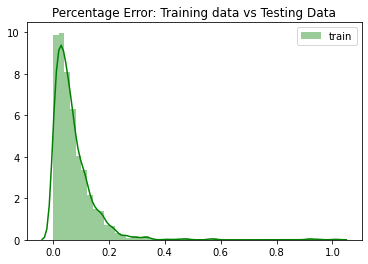

In [31]:
sns.distplot(train_percentage_error,color='g',label='train')
#sns.distplot(test_percentage_error,color='r',label='test')
plt.legend()
plt.title("Percentage Error: Training data vs Testing Data");

## Prediction of OLS

In [32]:
OLS_prediction = pd.DataFrame(np.exp(lin_regression.predict(test_data)))
OLS_prediction = OLS_prediction.rename(columns={0:'SalePrice'})
OLS_prediction.to_csv('E:/projects/housing_price/OLS_prediction.csv',columns=OLS_prediction.columns)

# Removing Insignificant Predictors

#### Based on the summary, there are a few predictors with small t-scores together with large p-values. It means that these predictors are weak predictors and should be taken out.

In [33]:
weak_predictors = ['LotFrontage','CentralAir','FireplaceQu','GarageFinish','RecentRemod','YrSold','MoSold','BsmtQual','BsmtCond',
                   'gabble_roof','LandContour_Lvl','Electrical','MasVnrArea','BedroomAbvGr','MiscVal','PoolArea','has_fence',
                   'LandSlope_Gtl','ExterScore','SaleCondition_Abnorml','SaleCondition_AdjLand','SaleCondition_Alloca',
                   'SaleCondition_Family','SaleCondition_Normal','3SsnPorch','LowQualFinSF']

In [34]:
weak_removed_train_data = train_data.drop(columns=weak_predictors)

In [35]:
weak_removed_test_data = test_data.drop(columns=weak_predictors)

In [36]:
weak_removed_train_data = sm.add_constant(weak_removed_train_data)
weak_removed_OLS = sm.OLS(log_house_price,weak_removed_train_data)
weak_removed_lin_regression = weak_removed_OLS.fit()
print(weak_removed_lin_regression.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     168.9
Date:                Thu, 16 Jul 2020   Prob (F-statistic):               0.00
Time:                        11:44:27   Log-Likelihood:                 1253.0
No. Observations:                1448   AIC:                            -2288.
Df Residuals:                    1339   BIC:                            -1713.
Df Model:                         108                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
LotAre

D:\anaconda\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [37]:
weak_removed_train_fitted_log_price = weak_removed_lin_regression.predict(weak_removed_train_data)
weak_removed_train_fitted_price = np.exp(weak_removed_train_fitted_log_price)
weak_removed_train_percentage_error = np.abs(house_price-weak_removed_train_fitted_price)/house_price
print("Average percentage error for training data: {}".format(sum(weak_removed_train_percentage_error)/len(weak_removed_train_percentage_error)))

#weak_removed_test_fitted_log_price = weak_removed_lin_regression.predict(weak_removed_test_data)
#weak_removed_test_fitted_price = np.exp(weak_removed_test_fitted_log_price)
#weak_removed_test_percentage_error = np.abs(np.exp(weak_removed_test_house_price)-weak_removed_test_fitted_price)/np.exp(weak_removed_test_house_price)
#print("Average percentage error for testing data: {}".format(sum(weak_removed_test_percentage_error)/len(weak_removed_test_percentage_error)))

Average percentage error for training data: 0.07372782175076624


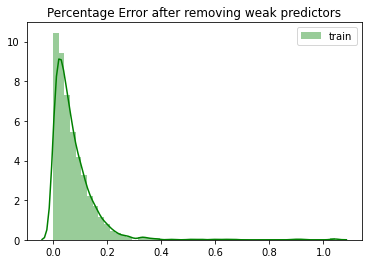

In [38]:
sns.distplot(weak_removed_train_percentage_error,color='g',label='train')
#sns.distplot(weak_removed_test_percentage_error,color='r',label='test')
plt.legend()
plt.title("Percentage Error after removing weak predictors");

# Weighted Linear Regression Fit

#### Get the weights from OLS model --- there are a few common and possible ways to determine weights, all of which aims at decoupling variance from the dependence on mean

In [41]:
# weights = 1/(house_price-train_fitted_price)**2
weights = house_price/ np.abs(house_price-train_fitted_price)
# weights = 1/np.log(train_fitted_price)
# weights = 1/np.log(train_fitted_price)**2

In [43]:
WLS = sm.WLS(log_house_price,train_data,weights=weights)

In [44]:
weighted_lin_regression = WLS.fit()

In [45]:
WLS_train_fitted_log_price = weighted_lin_regression.predict(train_data)
WLS_train_fitted_price = np.exp(WLS_train_fitted_log_price)
WLS_train_percentage_error = np.abs(house_price-WLS_train_fitted_price)/house_price
print("Average percentage error for training data: {}".format(sum(WLS_train_percentage_error)/len(train_percentage_error)))


Average percentage error for training data: 0.07016364517176095


In [46]:
print(weighted_lin_regression.summary())

                            WLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       1.000
Model:                            WLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.092e+10
Date:                Thu, 16 Jul 2020   Prob (F-statistic):               0.00
Time:                        11:46:03   Log-Likelihood:                 2225.2
No. Observations:                1448   AIC:                            -4180.
Df Residuals:                    1313   BIC:                            -3468.
Df Model:                         134                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
LotFro

In [47]:
WLS_prediction = pd.DataFrame(np.exp(weighted_lin_regression.predict(test_data)))

In [48]:
WLS_prediction = WLS_prediction.rename(columns={0:'SalePrice'})

In [51]:
WLS_prediction.to_csv('E:/projects/housing_price/WLS_prdiction.csv',columns=WLS_prediction.columns)